# Распознавание образов, описываемых гауссовскими случайными векторами с одинаковыми матрицами ковариаций

### 1. Задание исходных данных

In [63]:
import numpy as np
np.set_printoptions(precision=3)

In [29]:
m = np.matrix([[-5,1,0],[1,-4,8],[10,-2,1]]) #матожидания
C = np.matrix([[3, 1, 1],[1, 3, 1],[ 1, 1, 3]]) #матрица ковариаций
n = 3 #размерность признакового пространства
M = 3 #число классов
pw = np.array([0.4,0.2,0.4]) #апостериорные вероятности

In [87]:
#Условия из примера
# Для М = 2

m=np.matrix([[0, 4],[0, 1]])
n = 2
M = 2
pw = np.array([0.9,0.1])

# # Для М = 4

# m=np.matrix([[2, -2,2,-2],[2,2,-2,-2]])
# n = 2
# M = 4
# pw = np.array([0.4,0.2,0.1,0.3])


import math
C=np.zeros((n,n))
D=1
ro = 0.7
alf  = - math.log(ro)
for i in range(n):
    for j in range(n):
        C[i,j] = D*math.exp(-alf*abs(i-j))

In [3]:
#Вариант 7

# m = np.matrix([[3,1],[-1,7]]) 
# C = np.matrix([[3, 1],[1,4]])
# n = M = 2 
# pw = np.array([0.1,0.9])

### 2. Расчет разделяющих функций и вероятностей ошибок разпознавания

In [88]:
G = np.zeros((M,n+1))
P_err, l0 = np.zeros((M,M)), np.zeros((M,M))

In [89]:
C_ = np.linalg.inv(C)

In [90]:
from scipy.stats import norm

In [91]:
for i in range(M):
    G[i,:n] = np.transpose(C_*m[:,i])
    G[i,n] = -0.5*np.transpose(m[:,i])*C_*m[:,i]
    for j in range(i+1,M):
        l0[i,j] = np.log(pw[j]/pw[i])
        h = 0.5*np.transpose((m[:,i]-m[:,j]))*C_*(m[:,i]-m[:,j])
        sD = np.sqrt(2*np.abs(h))
        P_err[i,j] = norm.cdf(l0[i,j],h,sD)
        P_err[j,i] = 1 - norm.cdf(l0[i,j],-h,sD)
    P_err[i,i] = 1 - np.sum(P_err[i,:])

In [92]:
print(P_err)

[[ 0.998  0.002]
 [ 0.029  0.971]]


### 3. Тестирование алгоритма методом статистических испытаний

In [93]:
from numpy.linalg import cholesky
def randncor(n,N,C):
    try:
        A = cholesky(C)
    except LinAlgError:
        m=0
        print('A is not positive definite')
    m = n
    u = np.random.randn(m,N)
    x = A.conj().transpose().dot(u)
    return x     

In [94]:
x = np.matrix(np.ones((n+1,1)))
P_err_experiment = np.zeros((M,M))
K = 10000

In [95]:
for k in range(K):
    for i in range(M):
        x_ = randncor(n,1,C)
        x[:n,0] = m[:,i] + x_
        u = G*x+np.log(np.matrix(pw).conj().transpose())
        um,umi = u.max(), np.where(u == u.max())[0]
        P_err_experiment[i,umi] = P_err_experiment[i,umi]+1

In [96]:
P_err_experiment /=K 

In [97]:
P_err_experiment

array([[ 0.976,  0.024],
       [ 0.094,  0.906]])

### 4. Визуализация областей принятия решений

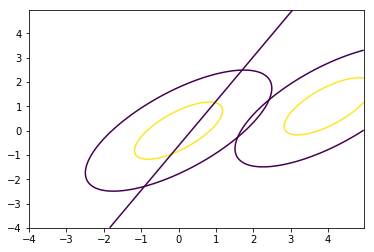

In [102]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

if n == 2:
    xmin1 = -4*math.sqrt(D)+ m[0,:].min()
    xmax1 =  4*math.sqrt(D)+ m[0,:].max()
    
    xmin2 = -4*math.sqrt(D)+ m[1,:].min()
    xmax2 =  4*math.sqrt(D)+ m[1,:].max()
    
    step = 0.05
    x1 = np.arange(xmin1,xmax2,step)
    x2 = np.arange(xmin2,xmax2,step)
    
    X1, X2 = np.meshgrid(x1,x2)
    x12=np.column_stack([X1.ravel(),X2.ravel()])
    
    fig, ax = plt.subplots()
    for i in range(M):
        f2 = multivariate_normal.pdf(x12,mean = np.array(m[:,i]).ravel(),cov = C)
        f3 = f2.reshape(len(x2),len(x1)).copy()
        ax.contour(x1, x2, f3,[0.01,0.5*max(f3.ravel())])
        ax.clabel(CS, inline=1, fontsize=10)
        for j in range(i+1,M):
            wij = C_*(m[:,i] - m[:,j])
            wij0 = -0.5*(m[:,i] + m[:,j]).conj().T*C_*(m[:,i] - m[:,j])
            f4 = wij.conj().T *x12.conj().T
            f5 = f4.reshape(len(x2),len(x1)).copy()
            ax.contour(x1,x2,f5,[l0[i,j]+0.0001])
    plt.show()